In [1]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm as tqdm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# custom libraries used
from models.grid_world import Experiment
from models.agents import IndependentClusterAgent, JointClusteringAgent, FlatAgent, MetaAgent
from models.experiment_designs.experiment2 import gen_task_param
sns.set_context('paper', font_scale=1.5)

In [2]:
n_sims = 114

# alpha is sample from the distribution
# log(alpha) ~ N(alpha_mu, alpha_scale)
alpha_mu = 0.0
alpha_scale = 1.0

inv_temp = 10.
goal_prior = 10e-20 
prunning_threshold = 10.0
evaluate = False

np.random.seed(0)

# pre generate a set of tasks for consistency. 
list_tasks = [gen_task_param() for _ in range(n_sims)]

# pre draw the alphas for consistency
list_alpha = [np.exp(scipy.random.normal(loc=alpha_mu, scale=alpha_scale)) 
              for _ in range(n_sims)]

def sim_agent(AgentClass, name='None', flat=False, meta=False):
    results = []
    for ii, (task_args, task_kwargs) in tqdm(enumerate(list_tasks), total=len(list_tasks)):

        if not flat:
            agent_kwargs = dict(alpha=list_alpha[ii], inv_temp=inv_temp, 
                                goal_prior=goal_prior)
        else:
            agent_kwargs = dict(inv_temp=inv_temp, goal_prior=goal_prior)
            
        if meta:
            agent_kwargs['mix_biases'] = [np.random.uniform(-3, 0), np.random.uniform(-3, 0)]
        
        agent = AgentClass(Experiment(*task_args, **task_kwargs), **agent_kwargs)
        
        _res = agent.generate(evaluate=evaluate, prunning_threshold=prunning_threshold)
        _res[u'Model'] = name
        _res[u'Iteration'] = [ii] * len(_res)
        results.append(_res)
    return pd.concat(results)

In [3]:
results_meta = sim_agent(MetaAgent, name='Meta', meta=True)
results_ic = sim_agent(IndependentClusterAgent, name='Independent')
results_jc = sim_agent(JointClusteringAgent, name='Joint')
results_fl = sim_agent(FlatAgent, name='Flat', flat=True)
results = pd.concat([results_ic, results_jc, results_fl, results_meta])

100%|██████████| 114/114 [08:20<00:00,  4.39s/it]
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [4]:
results = pd.concat([results_ic, results_jc, results_fl, results_meta])

/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## Model Predictions
Summary Statistics:

In [5]:
results['Training'] = results.Context < 8
results['Acc'] = pd.to_numeric(results.Reward)
results[results['In Goal']].groupby(['Training', 'Model']).mean()

Context  In Goal  Ind Weight  Iteration  \
Training Model                                                   
False    Flat         9.000000     True         NaN       56.5   
         Independent  9.000000     True         NaN       56.5   
         Joint        9.000000     True         NaN       56.5   
         Meta         9.000000     True  -65.280773       56.5   
True     Flat         3.927711     True         NaN       56.5   
         Independent  3.927711     True         NaN       56.5   
         Joint        3.927711     True         NaN       56.5   
         Meta         3.927711     True  -34.261727       56.5   

                      Joint Probability  Joint Weight  Key-press  Steps Taken  \
Training Model                                                                  
False    Flat                       NaN           NaN   2.812865     7.073587   
         Independent                NaN           NaN   2.811891     5.131579   
         Joint                      NaN           NaN   2.825049     6.338207   
         Meta                  0.700139    -54.883907   2.811404     5.942982   
True     Flat                       NaN           NaN   3.574614     5.440182   
         Independent                NaN           NaN   3.578102     5.056278   
         Joint                      NaN           NaN   3.579951     5.223579   
         Meta                  0.612234    -30.097412   3.581484     5.175439   

                      Times Seen Context  Trial Number       Acc  
Training Model                                                    
False    Flat                   3.500000    171.567739  0.722222  
         Independent            3.500000    171.567739  0.539961  
         Joint                  3.500000    171.567739  0.630117  
         Meta                   3.500000    171.567739  0.591131  
True     Flat                  14.463855     82.817956  0.919784  
         Independent           14.463855     82.817956  0.802526  
         Joint                 14.463855     82.817956  0.871697  
         Meta                  14.463855     82.817956  0.858170

In [6]:
results['Training'] = results.Context < 8
results['Acc'] = pd.to_numeric(results.Reward)
results[results['In Goal']].groupby(['Model']).mean()

,Context,In Goal,Ind Weight,Iteration,Joint Probability,Joint Weight,Key-press,Steps Taken,Times Seen Context,Trial Number,Training,Acc
Model,,,,,,,,,,,,
Flat,4.423913,1.0,NaN,56.5,NaN,NaN,3.500095,5.599971,13.391304,91.5,0.902174,0.900458
Independent,4.423913,1.0,NaN,56.5,NaN,NaN,3.503146,5.063644,13.391304,91.5,0.902174,0.776840
Joint,4.423913,1.0,NaN,56.5,NaN,NaN,3.506102,5.332618,13.391304,91.5,0.902174,0.848064
Meta,4.423913,1.0,-37.296199,56.5,0.620833,-32.522178,3.506150,5.250524,13.391304,91.5,0.902174,0.832046


In [25]:
from scipy.stats import ttest_ind

g = results[results['In Goal']].groupby(['Training', 'Model', 'Iteration']).mean()
# g.reset_index(inplace=True)


def print_model_norm(model):
    t, p = ttest_ind(g.loc[(True, 'Flat'),'Acc'], g.loc[(True, model),'Acc'])
    df = len(g.loc[(True, 'Flat'),'Acc']) * 2 -2
    M = g.loc[(True, model),'Acc'].mean() - g.loc[(True,'Flat'),'Acc'].mean()
    print "%s (Train):  M=%.3g, t(%d)=%.5g, p=%.3g" % (model, M, df, t, p)
    
    t, p = ttest_ind(g.loc[(False, 'Flat'),'Acc'], g.loc[(False, model),'Acc'])
    df = len(g.loc[(False, 'Flat'),'Acc']) * 2 -2
    M = g.loc[(False, model),'Acc'].mean() - g.loc[(False,'Flat'),'Acc'].mean()
    print "%s (Test) :  M=%.3g, t(%d)=%.5g, p=%.3g" % (model, M, df, t, p)

print_model_norm('Independent')
print_model_norm('Joint')
print_model_norm('Meta')


Independent (Train):  M=-0.117, t(226)=6.4289, p=7.55e-10
Independent (Test) :  M=-0.182, t(226)=7.9332, p=9.83e-14
Joint (Train):  M=-0.0481, t(226)=4.8487, p=2.31e-06
Joint (Test) :  M=-0.0921, t(226)=4.6329, p=6.09e-06
Meta (Train):  M=-0.0616, t(226)=5.8961, p=1.34e-08
Meta (Test) :  M=-0.131, t(226)=6.0398, p=6.29e-09


Plot the overall rewards collected in the training and test contexts

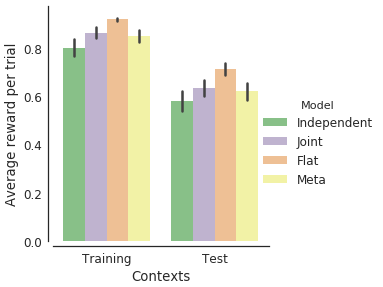

In [26]:
in_goal = results[results['In Goal'] ].copy()
in_goal['Contexts'] = [None] * len(in_goal)
in_goal.loc[in_goal.Context < 6, 'Contexts'] = 'Training'
in_goal.loc[in_goal.Context >= 7, 'Contexts'] = 'Test'

with sns.axes_style('white'):
    g = sns.factorplot(y='Reward', data=in_goal, x='Contexts', 
                   hue='Model', units='Iteration', kind='bar', 
                   estimator=np.mean, palette='Accent', size=4)
    sns.despine(offset=5, trim=False)
    ax = g.axes[0][0]
    ax.set_ylabel('Average reward per trial')

Break down the accuracy in each test context

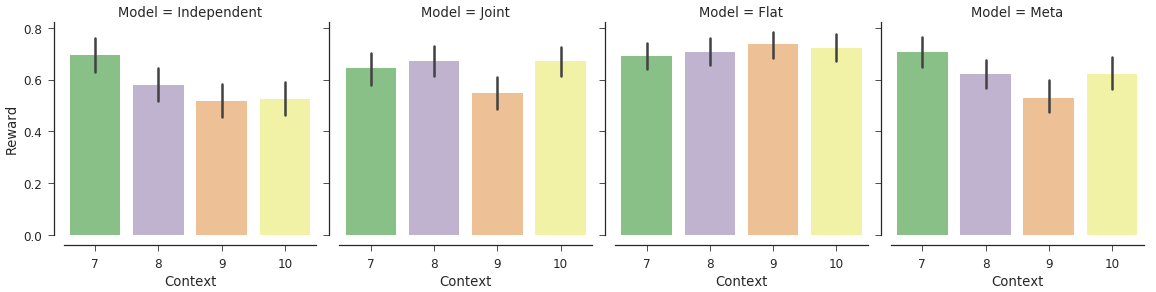

In [27]:
with sns.axes_style('ticks'):
    sns.factorplot(x='Context', y='Reward', data=in_goal[in_goal['Contexts'] == 'Test'], 
                   kind='bar', palette='Accent', col='Model', units='Iteration')
    g.set_xlabels(['T1', 'T2', 'T3', 'T4'])
    sns.despine(offset=10)

# Paper Figure
*Left*: Reward collected in test contexts across time

*Right*: Difference in reward collect between contexts across equated trials

/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/pandas/core/indexes/base.py:3064: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return self._engine.get_loc(key)


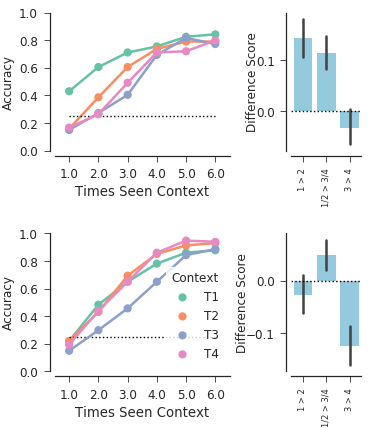

In [28]:
from matplotlib import gridspec

# plot the difference scores
df0 = results[results['In Goal'] & (results.Context >= 7) &
              (results['Model'] != 'Flat')
             ].copy()

score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 7, :
                            ].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8) | (subj_df.Context == 10), :
                       ].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 7) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 9) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']

        diff_3 = subj_df.loc[subj_df.Context == 9, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']


        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1+2 vs T3+4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))

score = pd.concat(score) 

df0 = results[results['In Goal'] & (results.Context >= 7) ].copy()
df0['Context'] += 1

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(5.5, 6.6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.6)
    axes = [
        [plt.subplot(gs[0]), plt.subplot(gs[1])],
        [plt.subplot(gs[2]),  plt.subplot(gs[3])]
    ]
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Independent'],  palette='Set2', ax=axes[0][0])
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Joint'],  palette='Set2', ax=axes[1][0])
    
    axes[0][0].legend_.remove() 
    ax = axes[1][0]
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    
    # plot difference scores on the right
    
    
    sns.barplot(x='Comparison', y='Difference Score', 
            data=score[score.Model == 'Independent'], color='skyblue', ax=axes[0][1])
    sns.barplot(x='Comparison', y='Difference Score',
            data=score[score.Model == 'Joint'], color='skyblue', ax=axes[1][1])
    
    for ii in [0, 1]:
        ax = axes[ii][0]
        ax.set_ylabel(r'Accuracy',  fontdict={'size':12})
        ax.plot([0, 5], [0.25, 0.25], 'k:')
        ax.set_ylim([0, 1])
    
    sns.despine(offset=5)

    for ii in [0, 1]:
        ax = axes[ii][1]
        ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
        ax.set_xlabel('')
        ax.plot([-1, 3], [0, 0], 'k:')
        plt.sca(ax)
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical',
                  fontsize='small')
        
    plt.savefig('Exp2_fig1.png', dpi=300)

In [29]:
df1 = score.groupby(['Model', 'Comparison','Iteration']).sum().reset_index()
print df1.groupby(['Model', 'Comparison']).mean().reset_index()
print df1.groupby(['Model', 'Comparison']).std().reset_index()

         Model    Comparison  Iteration  Difference Score  Trials in Context
0  Independent      T1 vs T2       56.5          0.859649               15.0
1  Independent  T1+2 vs T3+4       56.5          0.688596               15.0
2  Independent      T3 vs T4       56.5         -0.201754               15.0
3        Joint      T1 vs T2       56.5         -0.162281               15.0
4        Joint  T1+2 vs T3+4       56.5          0.298246               15.0
5        Joint      T3 vs T4       56.5         -0.750000               15.0
6         Meta      T1 vs T2       56.5          0.508772               15.0
7         Meta  T1+2 vs T3+4       56.5          0.526316               15.0
8         Meta      T3 vs T4       56.5         -0.543860               15.0
         Model    Comparison  Iteration  Difference Score  Trials in Context
0  Independent      T1 vs T2  33.052988          2.079726                0.0
1  Independent  T1+2 vs T3+4  33.052988          1.802641                0.0

In [30]:
from scipy.stats import ttest_1samp
def print_diff_stats(model_name):
    diff = score.groupby(['Model', 'Comparison','Iteration']).mean().reset_index()
    for c in set(score.Comparison):
        selection = (diff.Model == model_name) &(diff.Comparison == c)
        t, p = ttest_1samp(diff.loc[selection, 'Difference Score'].values, 0)
        df = len(diff.loc[selection, 'Difference Score'].values) - 1
        M = np.mean(diff.loc[selection, 'Difference Score'].values)
        print "%s: M=%.3g, t(%d)=%.5g, p=%.3g" % (c, M, df, t, p)

In [31]:
print_diff_stats('Independent')

T1 vs T2: M=0.143, t(114)=4.4133, p=2.34e-05
T3 vs T4: M=-0.0336, t(114)=-1.079, p=0.283
T1+2 vs T3+4: M=0.115, t(114)=4.0786, p=8.47e-05


In [32]:
print_diff_stats('Joint')

T1 vs T2: M=-0.027, t(114)=-0.77164, p=0.442
T3 vs T4: M=-0.125, t(114)=-4.1704, p=5.99e-05
T1+2 vs T3+4: M=0.0497, t(114)=1.8987, p=0.0602


In [33]:
print_diff_stats('Meta')

T1 vs T2: M=0.0848, t(114)=2.8449, p=0.00528
T3 vs T4: M=-0.0906, t(114)=-3.1067, p=0.00239
T1+2 vs T3+4: M=0.0877, t(114)=3.5672, p=0.00053


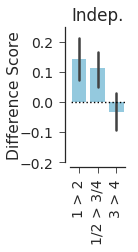

In [34]:
sns.set_context('paper', font_scale=1.75)
def plot_contrasts(model, model_name):
    with sns.axes_style('ticks'):
        fig, ax  = plt.subplots(figsize=(1.0, 2.5))    # plot difference scores on the right
        sns.barplot(x='Comparison', y='Difference Score', units='Iteration',
                data=score[score.Model == model], color='skyblue', ax=ax)
        ax.set_ylabel(r'Difference Score', labelpad=-3)
        ax.set_xlabel('')
        ax.plot([-1, 3], [0, 0], 'k:')
        ax.set_ylim([-0.2, 0.251])
        ax.set_yticks(np.arange(-0.2, 0.251, 0.1))
        sns.despine(offset=5)

        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
        ax.set_title(model_name)
    return fig 
fig = plot_contrasts('Independent', 'Indep.')
fig.savefig('Exp2_fig_model1.pdf', dpi=300, bbox_inches='tight')

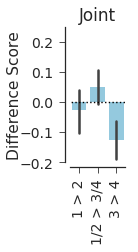

In [35]:
fig = plot_contrasts('Joint', 'Joint')
fig.savefig('Exp2_fig_model2.pdf', dpi=300, bbox_inches='tight')

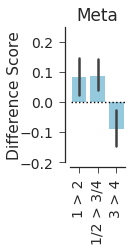

In [36]:
fig = plot_contrasts('Meta', 'Meta')
fig.savefig('Exp2_fig_model3.pdf', dpi=300, bbox_inches='tight')

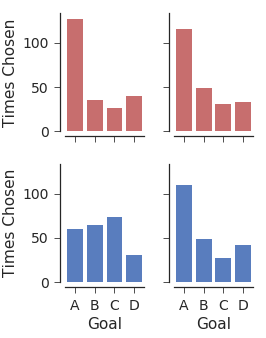

In [37]:
df0 = results[results['In Goal'] & (results.Context > 6) & 
               (results['Times Seen Context'] == 1) 
             & (results['Model'] != 'Flat')].copy()
df0['Map'] = ['1'] * len(df0)
df0.loc[(df0.Context == 7) | (df0.Context == 8), 'Map'] = 1
df0.loc[(df0.Context == 9) | (df0.Context == 10), 'Map'] = 2

cmap = "BrBG"
n = 3
# cc = [sns.color_palette(cmap, n_colors=16)[n], sns.color_palette(cmap, n_colors=16)[-(1+n)]]
cc = sns.color_palette('muted')
with sns.axes_style('ticks'):
    df0['Chosen'] = [1] * len(df0)
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(4, 5))
    
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 2)], ax=axes[0][0], color=cc[2])
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 1)], ax=axes[1][0], color=cc[0]) 
    
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 2)], ax=axes[0][1], color=cc[2])
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 1)], ax=axes[1][1], color=cc[0]) 
    
    for ii in [0, 1]:
        ax = axes[ii][0]
        ax.set_ylabel('Times Chosen')
        
        ax = axes[ii][1]
        ax.set_ylabel('')

        ax = axes[1][ii]
        ax.set_xlabel('Goal')

        ax = axes[0][ii]
        ax.set_xlabel('')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('Exp2_fig2.png', dpi=300)

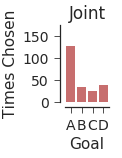

In [38]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 2)], ax=ax, color=cc[2])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Joint')
    ax.set_yticks([0,50,100, 150])
    ax.set_ylim([0, 175])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('exp2_qual1_joint.pdf', dpi=300, bbox_inches='tight')

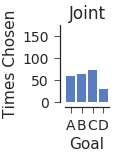

In [39]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 1)], ax=ax, color=cc[0])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Joint')
    ax.set_yticks([0,50,100, 150])
    ax.set_ylim([0, 175])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('exp2_qual2_joint.pdf', dpi=300, bbox_inches='tight')

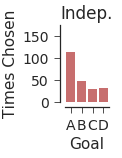

In [40]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 2)], ax=ax, color=cc[2])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Indep.')
    ax.set_yticks([0,50,100, 150])
    ax.set_ylim([0, 175])
    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    
    plt.tight_layout()
    plt.savefig('exp2_qual1_indep.pdf', dpi=300, bbox_inches='tight')

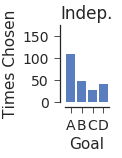

In [41]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 1)], ax=ax, color=cc[0])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Indep.')
    ax.set_yticks([0,50,100, 150])
    ax.set_ylim([0, 175])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('exp2_qual2_indep.pdf', dpi=300, bbox_inches='tight')

In [42]:
df0 = results[results['In Goal'] & (results.Context > 6) & 
               (results['Times Seen Context'] == 1) 
             & (results['Model'] != 'Flat')].copy()
df0['Map'] = ['1'] * len(df0)
df0.loc[(df0.Context == 7) | (df0.Context == 8), 'Map'] = 1
df0.loc[(df0.Context == 9) | (df0.Context == 10), 'Map'] = 2

cc = sns.color_palette('muted')
df0['Chosen'] = [1] * len(df0)

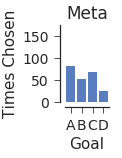

In [43]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Meta') & (df0.Map == 1)], ax=ax, color=cc[0])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Meta')
    ax.set_yticks([0,50,100, 150])
    ax.set_ylim([0, 175])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('exp2_qual2_meta.pdf', dpi=300, bbox_inches='tight')

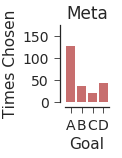

In [44]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Meta') & (df0.Map == 2)], ax=ax, color=cc[2])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Meta')
    ax.set_yticks([0,50,100, 150])
    ax.set_ylim([0, 175])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('exp2_qual1_meta.pdf', dpi=300, bbox_inches='tight')

In [45]:
#within subject errorbars (standard error)
df0 = results[results['In Goal'] & (results.Context > 6)
             & (results['Model'] != 'Flat')].copy()


cc = sns.color_palette('Set2')
def plot_test_context(m, c, ax, color, label):
    ctx = df0.loc[(df0['Times Seen Context'] < 6) & (df0['Context'] == c) & 
                  (df0['Model'] == m), 'Reward'
                ].values.reshape(n_sims, -1)
    ctx_std_err = np.array(ctx - np.tile(ctx.mean(axis=1), (5, 1)).T +\
                           np.tile(ctx.mean(), np.shape(ctx)),dtype='float').std(axis=0) / np.sqrt(n_sims)

    plt.plot(range(1, 6), ctx.mean(axis=0), color=color, label=label,
                linewidth=0, marker='.', markersize=15)
    (_, caps, _) = plt.errorbar(range(1, 6), ctx.mean(axis=0), ctx_std_err, color=color,
                linewidth=3)
    
from scipy.stats import ttest_1samp
def print_diff_stats(model_name):
    diff = score.groupby(['Model', 'Comparison','Iteration']).mean().reset_index()
    for c in set(score.Comparison):
        selection = (diff.Model == model_name) &(diff.Comparison == c)
        t, p = ttest_1samp(diff.loc[selection, 'Difference Score'].values, 0)
        df = len(diff.loc[selection, 'Difference Score'].values)
        M = np.mean(diff.loc[selection, 'Difference Score'].values)
        print "%s: M=%.3g, t(%d)=%.5g, p=%.3g" % (c, M, df, t, p)
    
def plot_model_test_context(model):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(3,3))
        plot_test_context(model, 7, ax, cc[0], 'T1')
        plot_test_context(model, 8, ax, cc[1], 'T2')
        plot_test_context(model, 9, ax, cc[2], 'T3')
        plot_test_context(model, 10, ax, cc[3], 'T4')
        legend = ax.legend(title="Context", loc='lower right', frameon=1, fontsize=12)
        legend.get_frame().set_edgecolor('w')
        ax.get_legend().get_title().set_fontsize(12)
        ax.set_xticks(range(1, 6))
        ax.set_xlabel('Times Seen Context', fontsize=15)
        ax.set_ylabel('Accuracy', fontsize=15)
        ax.plot([1, 5], [1./4, 1./4], 'k:')
        ax.set_ylim([0, 1])
        plt.title(model, fontsize=18, fontname='Helvetica')
        sns.despine(offset=5)

In [46]:
print_diff_stats('Joint')

T1 vs T2: M=-0.027, t(114)=-0.77164, p=0.442
T3 vs T4: M=-0.125, t(114)=-4.1704, p=5.99e-05
T1+2 vs T3+4: M=0.0497, t(114)=1.8987, p=0.0602


In [47]:
print_diff_stats('Independent')

T1 vs T2: M=0.143, t(114)=4.4133, p=2.34e-05
T3 vs T4: M=-0.0336, t(114)=-1.079, p=0.283
T1+2 vs T3+4: M=0.115, t(114)=4.0786, p=8.47e-05


In [48]:
print_diff_stats('Meta')

T1 vs T2: M=0.0848, t(114)=2.8449, p=0.00528
T3 vs T4: M=-0.0906, t(114)=-3.1067, p=0.00239
T1+2 vs T3+4: M=0.0877, t(114)=3.5672, p=0.00053


/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/sit

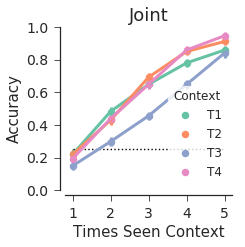

In [49]:
plot_model_test_context("Joint")
plt.savefig('Exp2_fig1b.pdf', dpi=300, bbox_inches='tight')

/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/sit

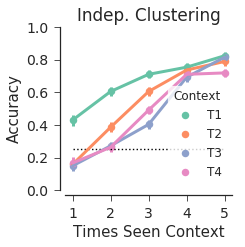

In [50]:
plot_model_test_context('Independent')
plt.title('Indep. Clustering')
plt.savefig('Exp2_fig1a.pdf', dpi=300, bbox_inches='tight')

/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/nick/anaconda2/envs/compgen/lib/python2.7/sit

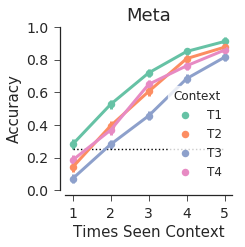

In [51]:
plot_model_test_context('Meta')
# plt.title('Indep. Clustering')

Plot the model responsibilities over time

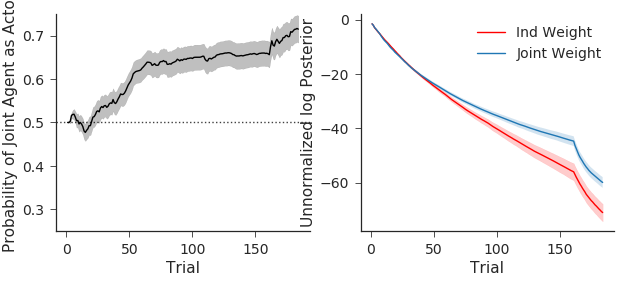

In [52]:
with sns.axes_style('ticks'):

    df0 = results[(results['Steps Taken']==1) & 
                  (results['Model'] == 'Meta')
                 ].copy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    x = range(1, int(df0['Trial Number'].max()) + 2)
    y = df0.groupby('Trial Number')['Joint Probability'].mean()
    y_err = df0.groupby('Trial Number')['Joint Probability'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'k-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.25, color='k')
    ax.set_ylabel('Probability of Joint Agent as Actor')
    ax.set_xlabel('Trial')
    xlb, xub = ax.get_xlim()
    ax.plot([xlb, xub], [0.5, 0.5], 'k:', alpha=0.75)
    ax.set_xlim(xlb, xub)
    ax.set_ylim([0.25, 0.75])

    ax = axes[1]
    y = df0.groupby('Trial Number')['Ind Weight'].mean()
    y_err = df0.groupby('Trial Number')['Ind Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'r-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2, color='r')

    y = df0.groupby('Trial Number')['Joint Weight'].mean()
    y_err = df0.groupby('Trial Number')['Joint Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, '-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)
    plt.legend(loc='best')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Unnormalized log Posterior')    
    ax.set_xlim(xlb, xub)

    plt.subplots_adjust(hspace=0.3)
    sns.despine()
    plt.savefig('Exp2_fig4.pdf', dpi=300)